In [ ]:
import os
import math
import pandas as pd
import numpy as np
import umap

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    test, 
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters

In [10]:
# Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# with the CHROM:POS for every corresponding RSID
"""
# GTM data
path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
path_raw = f"{CONFIG['PATH_data']}/01_raw/"
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

geno = make_df(path_data_raw, path_usefull, path_raw)

afs = calculate_AFs(geno)

path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)
"""
# Divide the AFs into chunks

size_chunck = 20_000
min_maf = 0.01

path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)

# Choose SNPs to project on n dimensions

In [11]:
path_input = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
path_output = f"{CONFIG['PATH_data']}/04_projected/"
nr_of_projected_dimensions = 3
project_on_dimensions(path_input, path_output, nr_of_projected_dimensions)


# Observe raw dimensions

In [4]:
path_input = f"{CONFIG['PATH_data']}/04_projected/snp_ids.pkl"
pd.read_pickle(path_input)

,pval,betas,snp_rs,-logp,dim
139,1.087519e-80,-10.504848,rs10803434_A,79.963563,1
689,7.039231e-80,-10.490837,rs11802371_G,79.152475,1
18,2.903497e-68,9.772897,rs12743883_G,67.537079,1
321,3.603211e-65,-9.523461,rs4424509_G,64.443310,1
249,6.203306e-65,9.459786,rs12035482_G,64.207377,1
...,...,...,...,...,...
156,9.019637e-01,0.075368,rs78164537_G,0.044811,3
160,9.221668e-01,0.060512,rs572271810_A,0.035190,3
106,9.299344e-01,-0.029379,rs1009059_C,0.031548,3
138,9.481962e-01,-0.031547,rs6002288_A,0.023102,3


In [14]:
path_input = f"{CONFIG['PATH_data']}/04_projected/"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/02_usefull/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
    path_PC = f"{path_dim}/{PCs}"
    PC_dim = pd.read_pickle(path_PC)
    merged_df[dim] = PC_dim['PC1']
    

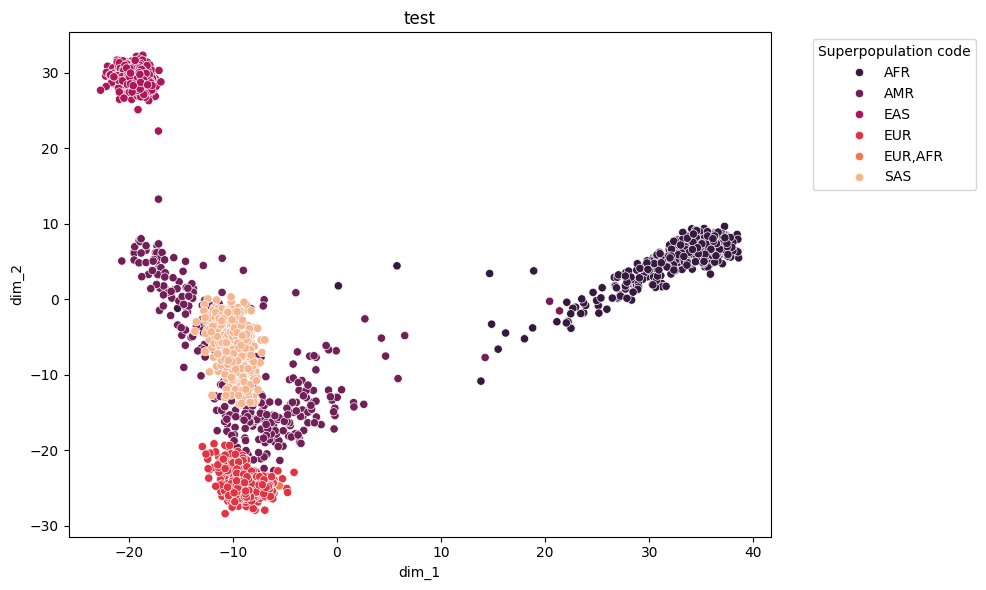

In [15]:
make_population_plot(merged_df, 'dim_1', 'dim_2', 'Superpopulation code', 'test', palette = 'rocket')

In [11]:
"""
N_PCs = 2
N_snps_block = 100

path_input = f"{CONFIG['PATH_data']}/04_projected/"
path_output = f"{CONFIG['PATH_data']}/05_ld_blocks/"

for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:
        path_input_chrom = f"{path_dim}/{chrom}/"
        path_output_chrom = f"{path_output}/{dim}/{chrom}/"
        os.makedirs(path_output_chrom, exist_ok=True)
        for file in os.listdir(path_input_chrom):
            filename = file.split(".pkl")[0]
            segmenter(path_input_chrom, path_output_chrom, filename , N_PCs, N_snps_block)
"""

'\nN_PCs = 2\nN_snps_block = 100\n\npath_input = f"{CONFIG[\'PATH_data\']}/04_projected/"\npath_output = f"{CONFIG[\'PATH_data\']}/05_ld_blocks/"\n\nfor dim in os.listdir(path_input):\n    path_dim = f"{path_input}/{dim}"\n    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:\n        path_input_chrom = f"{path_dim}/{chrom}/"\n        path_output_chrom = f"{path_output}/{dim}/{chrom}/"\n        os.makedirs(path_output_chrom, exist_ok=True)\n        for file in os.listdir(path_input_chrom):\n            filename = file.split(".pkl")[0]\n            segmenter(path_input_chrom, path_output_chrom, filename , N_PCs, N_snps_block)\n'

In [39]:

"""
path_input = f"{CONFIG['PATH_data']}/05_LD_blocks/"
path_output = f"{CONFIG['PATH_data']}/06_esti_mafs/"
n_components = 4

for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:
        path_input_chrom = f"{path_dim}/{chrom}/"
        path_output_chrom = f"{path_output}/{dim}/{chrom}/"
        blocks = [f for f in os.listdir(path_input_chrom) if f.startswith("block")]
        for block in blocks:
            linear_abyss(path_input_chrom, block, path_output_chrom, n_components, p2=True, twopq=True, q2=True)
"""

In [40]:
"""
# Align all the dataframes
path_input = f"{CONFIG['PATH_data']}/06_esti_mafs/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:
        path_input_chrom = f"{path_dim}/{chrom}"
        blocks = [f for f in os.listdir(f"{path_input_chrom}/q2") if f.startswith("block")]
        for block in blocks:
            path_q2 = f"{path_input_chrom}/q2/{block}"
            path_2pq = f"{path_input_chrom}/2pq/{block}"
            path_p2 = f"{path_input_chrom}/p2/{block}"
            minaf = pd.read_pickle(path_q2)
            hetaf = pd.read_pickle(path_2pq)
            majaf = pd.read_pickle(path_p2)
            # Example usage with your loaded DataFrames
            minaf, hetaf, majaf = align_dataframes(minaf, hetaf, majaf)
            minaf.to_pickle(f"{path_input_chrom}/q2/{block}")
            hetaf.to_pickle(f"{path_input_chrom}/2pq/{block}")
            majaf.to_pickle(f"{path_input_chrom}/p2/{block}")
"""


In [ ]:
"""
path_input = f"{CONFIG['PATH_data']}/06_esti_mafs/"
path_output = f"{CONFIG['PATH_data']}/07_esti_Fst/"

dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    path_output_dim = f"{path_output}/{dim}"
    chroms = [f for f in os.listdir(path_dim) if f.startswith("chrom")]
    for chrom in chroms:
        path_input_chrom = f"{path_dim}/{chrom}/"
        path_output_chrom = f"{path_output_dim}/{chrom}/"
        os.makedirs(path_output_chrom, exist_ok=True)
        files = [f for f in os.listdir(f"{path_input_chrom}/p2/") if f.startswith("block")]
        for file in files:
            make_fst(path_input_chrom, file, path_output_chrom)
"""

In [2]:


path_input = f"{CONFIG['PATH_data']}/07_esti_Fst/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    os.makedirs(path_dim, exist_ok=True)
    make_global_fst(path_dim, path_dim)


In [10]:
path_afs = f"{CONFIG['PATH_data']}/usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/usefull/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")

path_input = f"{CONFIG['PATH_data']}/07_esti_Fst/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    Fst_global = pd.read_pickle(f"{path_dim}/global_Fst.pkl")
    
    reducer = umap.UMAP(n_components=1, metric='precomputed', random_state=42)
    embedding = reducer.fit_transform(Fst_global)
    merged_df[[f"{dim}"]] = embedding

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/pytho

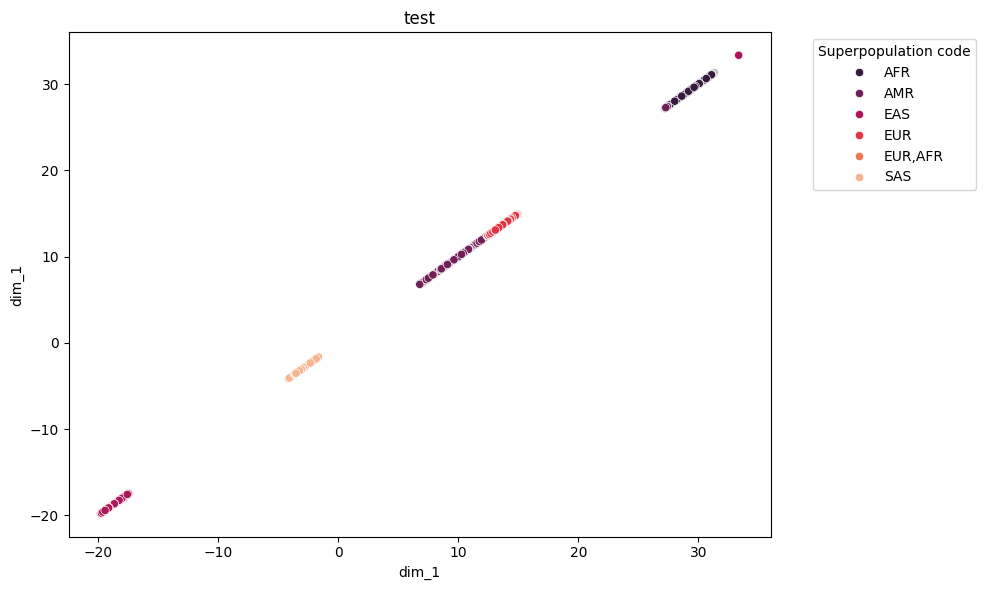

In [11]:
make_population_plot(merged_df, 'dim_1', 'dim_1', 'Superpopulation code', 'test', palette = 'rocket')


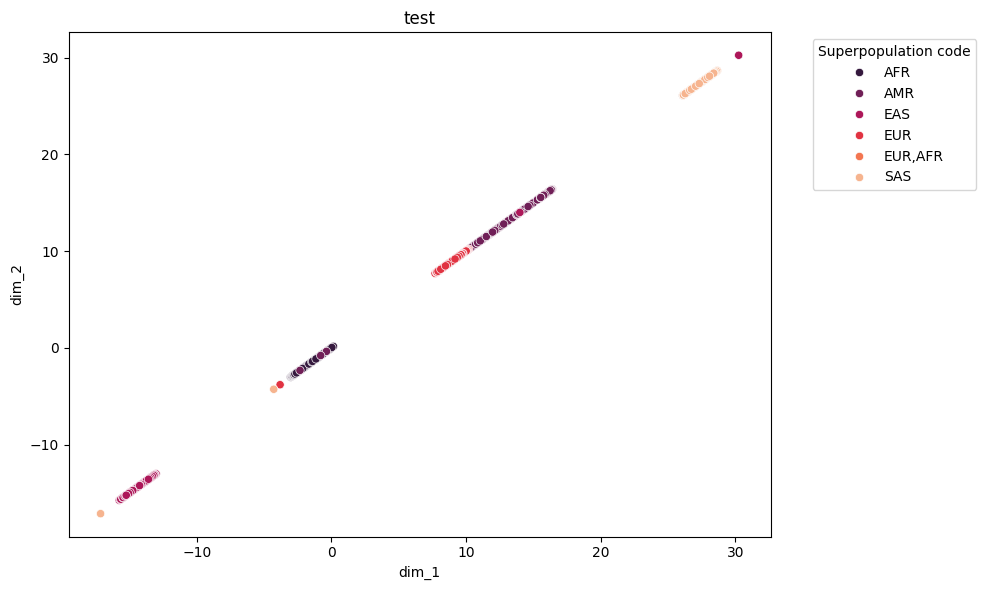

In [6]:
from sklearn.manifold import TSNE

path_afs = f"{CONFIG['PATH_data']}/usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/usefull/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")

path_input = f"{CONFIG['PATH_data']}/07_esti_Fst/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    Fst_global = pd.read_pickle(f"{path_dim}/global_Fst.pkl")
    # Compute 1D t-SNE embedding with the correct init parameter
    tsne = TSNE(n_components=1, metric='precomputed', init='random', random_state=42)
    embeddings = tsne.fit_transform(Fst_global)
    merged_df[[f"{dim}"]] = embedding

make_population_plot(merged_df, 'dim_1', 'dim_2', 'Superpopulation code', 'test', palette = 'rocket')


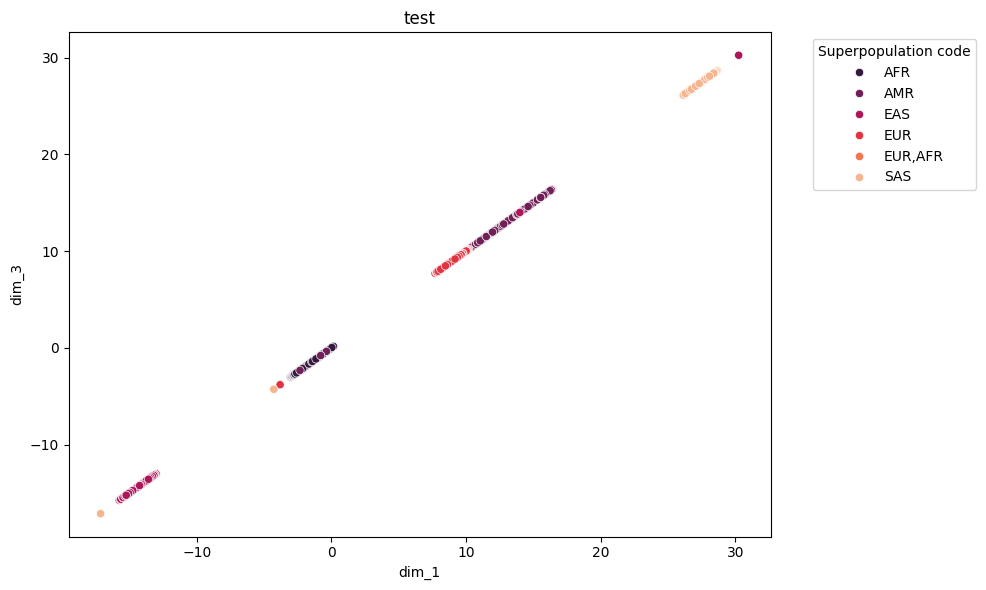

In [8]:
make_population_plot(merged_df, 'dim_1', 'dim_3', 'Superpopulation code', 'test', palette = 'rocket')
